This notebook takes the combined run- and experiment-wide metrics of each sequence-charge, and builds a run-specific estimator for intensity delta.

X is a sequence's attributes in a run:
- log2 intensity
- uncalibrated m/z (the raw intensity as extracted by TFD)
- charge
- retention time
- CCS

y is the delta of intensity in a run from the median intensity of the sequence over the experiment.

For training, filter:
- human only
- only sequences detected in at least half the runs
- only 1to1 runs

In [2]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import matplotlib.pyplot as plt

In [74]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV,ShuffleSplit,RandomizedSearchCV

In [4]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [6]:
SEQUENCES_WITH_SPECIES_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/sequences-with-species-df.pkl'

In [7]:
sequences_with_species_df = pd.read_pickle(SEQUENCES_WITH_SPECIES_FILE_NAME)

In [8]:
sequences_with_species_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity', 'classed_as', 'run_name',
       'batch', 'human'],
      dtype='object')

In [9]:
sequences_with_species_df.isnull().sum()

sequence      0
charge        0
file_idx      0
intensity     0
classed_as    0
run_name      0
batch         0
human         0
dtype: int64

In [10]:
TARGET_DECOY_MODEL_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/target-decoy-models'
EXPERIMENT_METRICS_FILE_NAME = "{}/experiment-metrics-for-library-sequences.pkl".format(TARGET_DECOY_MODEL_DIR)

In [11]:
experiment_metrics_for_library_sequences_df = pd.read_pickle(EXPERIMENT_METRICS_FILE_NAME)

In [12]:
experiment_metrics_for_library_sequences_df.columns

Index(['sequence', 'charge', 'theoretical_mz', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'experiment_scan_peak_width',
       'experiment_rt_mean', 'experiment_rt_std_dev',
       'experiment_rt_peak_width', 'experiment_intensity_mean',
       'experiment_intensity_std_dev', 'number_of_runs_identified', 'q_value',
       'file_idx', 'target_coords', 'decoy_coords', 'target_metrics',
       'attributes', 'decoy_metrics'],
      dtype='object')

In [13]:
experiment_metrics_for_library_sequences_df.isnull().sum()

sequence                           0
charge                             0
theoretical_mz                     0
experiment_scan_mean               0
experiment_scan_std_dev            0
experiment_scan_peak_width         0
experiment_rt_mean                 0
experiment_rt_std_dev              0
experiment_rt_peak_width           0
experiment_intensity_mean          0
experiment_intensity_std_dev       0
number_of_runs_identified          0
q_value                            0
file_idx                           0
target_coords                      0
decoy_coords                       0
target_metrics                  1157
attributes                         0
decoy_metrics                   6537
dtype: int64

Merge the unpacked attributes of the TFD-extracted sequence (in experiment_metrics_for_library_sequences_df) with the sequences_with_species_df

In [14]:
# unpack the TFD-extracted attributes from each sequence
attributes = []
attribute_names = [key for key in sorted(experiment_metrics_for_library_sequences_df.iloc[0].attributes)]

for row in experiment_metrics_for_library_sequences_df.itertuples():
    # target metric values
    d = row.attributes
    if (d is not None) and all(d.values()):
        l = []
        l.append(row.sequence)
        l.append(row.charge)
        l.append(row.file_idx)
        l += [d[key] for key in sorted(d)]
        attributes.append(tuple(l))

columns = ['sequence','charge','file_idx']
columns += attribute_names

attributes_as_extracted_df = pd.DataFrame(attributes, columns=columns)

In [15]:
attributes_as_extracted_df.isnull().sum()

sequence                0
charge                  0
file_idx                0
intensity_all_points    0
intensity_top_3         0
monoisotopic_mz         0
rt_apex                 0
scan_apex               0
dtype: int64

In [16]:
len(attributes_as_extracted_df)

586547

In [17]:
attributes_as_extracted_df.head()

,sequence,charge,file_idx,intensity_all_points,intensity_top_3,monoisotopic_mz,rt_apex,scan_apex
0,AAAAAAAAAAAAAAAASAGGK,2,0,1956,331,778.415635,937.100303,533.000000
1,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,0,321139,6502,1184.609205,594.503517,70.440081
2,AAAAAAAAVPSAGPAGPAPTSAAGR,2,0,3014,328,1016.532371,486.625154,152.472187
3,AAAAATVVPPMVGGPPFVGPVGFGPGDR,3,0,8014,336,864.452576,1034.987311,708.747001
4,AAAAAWEEPSSGNGTAR,2,0,76396,1762,823.382040,367.242494,538.177052


In [18]:
len(sequences_with_species_df)

544165

In [19]:
sequences_with_attributes_df = pd.merge(attributes_as_extracted_df, sequences_with_species_df, how='inner', left_on=['sequence','charge','file_idx'], right_on=['sequence','charge','file_idx'])

In [20]:
sequences_with_attributes_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity_all_points',
       'intensity_top_3', 'monoisotopic_mz', 'rt_apex', 'scan_apex',
       'intensity', 'classed_as', 'run_name', 'batch', 'human'],
      dtype='object')

In [21]:
sequences_with_attributes_df.isnull().sum()

sequence                0
charge                  0
file_idx                0
intensity_all_points    0
intensity_top_3         0
monoisotopic_mz         0
rt_apex                 0
scan_apex               0
intensity               0
classed_as              0
run_name                0
batch                   0
human                   0
dtype: int64

In [22]:
len(sequences_with_attributes_df)

542616

In [23]:
# calculate median intensity for each sequence in the experiment - just human and 1to1
sequences_with_attributes_df = sequences_with_attributes_df[(sequences_with_attributes_df.human == True) & (sequences_with_attributes_df.batch == '1to1')]

# find the experiment-wide intensity median
experiment_intensities_l = []
for group_name,group_df in sequences_with_attributes_df.groupby(['sequence','charge'], as_index=False):
    number_of_runs_for_sequence = len(group_df)
    median_intensity_in_experiment = group_df.intensity_top_3.median()
    sequence = group_name[0]
    charge = group_name[1]
    experiment_intensities_l.append((sequence,charge,median_intensity_in_experiment,number_of_runs_for_sequence))

experiment_intensities_df = pd.DataFrame(experiment_intensities_l, columns=['sequence','charge','median_intensity_in_experiment','number_of_runs_identified'])

In [24]:
experiment_intensities_df.head()

,sequence,charge,median_intensity_in_experiment,number_of_runs_identified
0,AAAAAAAAAAAAAAAASAGGK,2,371.0,10
1,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,2169.0,10
2,AAAAAAAAAPAAAATAPTTAATTAATAAQ,3,396.0,7
3,AAAAAAAAVPSAGPAGPAPTSAAGR,2,446.5,10
4,AAAAALSQQQSLQER,2,699.0,10


In [209]:
training_set_df = pd.merge(sequences_with_attributes_df, experiment_intensities_df, how='inner', left_on=['sequence','charge'], right_on=['sequence','charge'])

In [210]:
training_set_df.head()

,sequence,charge,file_idx,intensity_all_points,intensity_top_3,monoisotopic_mz,rt_apex,scan_apex,intensity,classed_as,run_name,batch,human,median_intensity_in_experiment,number_of_runs_identified
0,AAAAAAAAAAAAAAAASAGGK,2,1,25238,493,778.413822,941.074672,524.190759,493,target,190719_Hela_Ecoli_1to1_07,1to1,True,371.0,10
1,AAAAAAAAAAAAAAAASAGGK,2,2,4679,399,778.413926,958.106323,491.231962,399,target,190719_Hela_Ecoli_1to1_09,1to1,True,371.0,10
2,AAAAAAAAAAAAAAAASAGGK,2,6,3189,312,778.413890,941.712078,489.059477,312,target,190719_Hela_Ecoli_1to1_03,1to1,True,371.0,10
3,AAAAAAAAAAAAAAAASAGGK,2,8,13534,829,778.413947,913.778646,549.826553,829,target,190719_Hela_Ecoli_1to1_10,1to1,True,371.0,10
4,AAAAAAAAAAAAAAAASAGGK,2,10,3475,393,778.413886,1002.229545,492.093016,393,target,190719_Hela_Ecoli_1to1_08,1to1,True,371.0,10


In [211]:
training_set_df['intensity_delta'] = training_set_df.median_intensity_in_experiment - training_set_df.intensity_top_3
training_set_df['log_intensity_delta'] = np.log2(np.power(np.abs(training_set_df.intensity_delta), np.sign(training_set_df.intensity_delta)))
training_set_df['log_intensity'] = np.log2(np.power(np.abs(training_set_df.intensity), np.sign(training_set_df.intensity)))

In [235]:
training_set_df.tail()

,sequence,charge,file_idx,intensity_all_points,intensity_top_3,monoisotopic_mz,rt_apex,scan_apex,intensity,classed_as,run_name,batch,human,median_intensity_in_experiment,number_of_runs_identified,intensity_delta,log_intensity_delta,log_intensity
216564,YNPMYSEPVDQEYLPEELR,2,2,554,166,1186.540321,804.388525,104.000000,166,target,190719_Hela_Ecoli_1to1_09,1to1,True,293.0,9,127.0,6.988685,7.375039
216573,YQQQYLQPLPLTHYELVTDAFGHR,4,2,682,184,730.119498,924.974680,619.386906,184,target,190719_Hela_Ecoli_1to1_09,1to1,True,329.0,8,145.0,7.179909,7.523562
216581,YSAHSSHVTNVSFTHNDSHLISTGGK,3,2,2589,261,928.442358,388.312760,314.862810,261,target,190719_Hela_Ecoli_1to1_09,1to1,True,275.0,7,14.0,3.807355,8.027906
216588,YSFIQALVR,2,2,4842,678,548.810772,855.699639,856.719155,678,target,190719_Hela_Ecoli_1to1_09,1to1,True,577.0,6,-101.0,-6.658211,9.405141
216594,YSNEDTLSVALPYFWEHFDK,3,2,8967,286,821.049453,1081.428171,581.993548,286,target,190719_Hela_Ecoli_1to1_09,1to1,True,422.5,8,136.5,7.092757,8.159871


In [213]:
training_set_df.isnull().sum()

sequence                          0
charge                            0
file_idx                          0
intensity_all_points              0
intensity_top_3                   0
monoisotopic_mz                   0
rt_apex                           0
scan_apex                         0
intensity                         0
classed_as                        0
run_name                          0
batch                             0
human                             0
median_intensity_in_experiment    0
number_of_runs_identified         0
intensity_delta                   0
log_intensity_delta               0
log_intensity                     0
dtype: int64

In [214]:
training_set_df.file_idx.unique()

array([ 1,  2,  6,  8, 10, 11, 15, 16, 18, 19])

In [215]:
file_idx_for_this_model = 2

In [216]:
# filter out rows we don't want in the training set for this run-specific model
training_set_df = training_set_df[(training_set_df.file_idx == file_idx_for_this_model) & (training_set_df.number_of_runs_identified > 5)]

In [217]:
print("there are {} sequences in the training set for file {}".format(len(training_set_df), file_idx_for_this_model))

21243

In [321]:
# split the training set
X = training_set_df[['intensity','monoisotopic_mz','rt_apex','scan_apex','charge']].values
y = training_set_df[['intensity_delta','median_intensity_in_experiment']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

#### intensity estimation model

In [322]:
def GradientBooster(param_grid, n_jobs, X_train, y_train):
    estimator = GradientBoostingRegressor()
    cv = ShuffleSplit(n_splits=10, train_size=0.8, test_size=0.2, random_state=0)
    classifier = RandomizedSearchCV(estimator=estimator, cv=cv, param_distributions=param_grid, n_jobs=n_jobs)
    classifier.fit(X_train, y_train)
    print('best estimator found: {}'.format(classifier.best_estimator_))
    return cv, classifier.best_estimator_


In [323]:
# search for the best model in the specified hyperparameter space
parameter_search_space = {'n_estimators':[500, 800, 1000], 
                          'learning_rate': [0.1, 0.05, 0.02, 0.01], 
                          'max_depth':[20, 10, 6, 4], 
                          'min_samples_leaf':[3, 5, 9, 17], 
                          'max_features':[1.0, 0.3, 0.1],
                          'loss':['ls', 'lad', 'huber', 'quantile']
                         }
n_jobs = 4
cv, best_estimator = GradientBooster(parameter_search_space, n_jobs, X_train, y_train[:,1])


best estimator found: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='huber', max_depth=6,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [324]:
params = {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 5, 'max_features': 1.0, 'loss':'huber'}

In [325]:
best_estimator = GradientBoostingRegressor(**params)

In [326]:
# use the best parameters to train the model
best_estimator.fit(X_train, y_train[:,1])
print("R-squared for training set: {}".format(best_estimator.score(X_train, y_train[:,1])))
print("R-squared for test set: {}".format(best_estimator.score(X_test, y_test[:,1])))

R-squared for training set: 0.916647056055103
R-squared for test set: 0.8315403446652577


In [327]:
feature_names = np.array(['intensity','monoisotopic_mz','rt_apex','scan_apex','charge'])

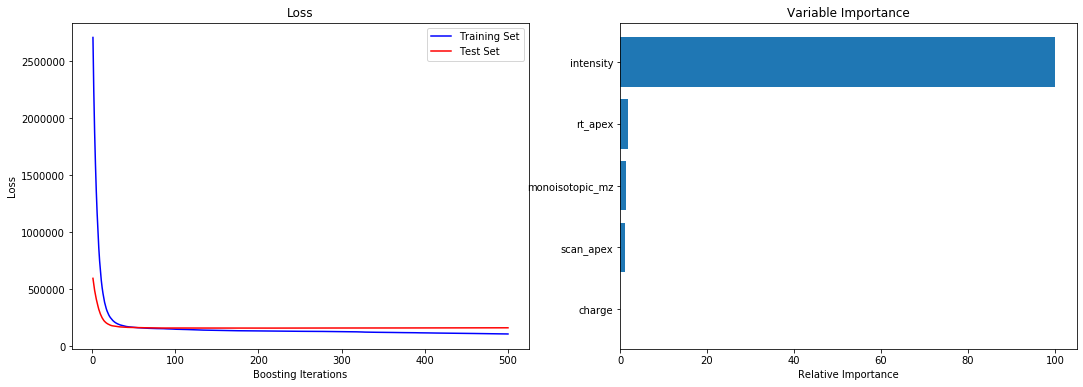

In [328]:
# Plot training loss

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(best_estimator.staged_predict(X_test)):
    test_score[i] = best_estimator.loss_(y_test[:,1], y_pred)

plt.figure(figsize=(18, 6))
plt.margins(0.06)
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(params['n_estimators']) + 1, best_estimator.train_score_, 'b-', label='Training Set')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label='Test Set')
plt.legend(loc='best')
plt.xlabel('Boosting Iterations')
plt.ylabel('Loss')

# Plot feature importance
feature_importance = best_estimator.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

plt.show()

In [329]:
# use the trained model to predict the intensity delta for the test set
y_test_predicted = best_estimator.predict(X_test)

In [330]:
intensity_df = pd.DataFrame()
intensity_df['pre_adjustment_intensity_error'] = X_test[:,0] - y_test[:,1]
intensity_df['post_adjustment_intensity_error'] = y_test_predicted - y_test[:,1]
std_dev_before = intensity_df.pre_adjustment_intensity_error.std()
std_dev_after = intensity_df.post_adjustment_intensity_error.std()
median_before = intensity_df.pre_adjustment_intensity_error.median()
median_after = intensity_df.post_adjustment_intensity_error.median()
mean_before = intensity_df.pre_adjustment_intensity_error.mean()
mean_after = intensity_df.post_adjustment_intensity_error.mean()

In [331]:
std_dev_before, std_dev_after

(1205.6919353412993, 1190.2061443031764)

In [332]:
median_before, median_after

(-39.5, 18.57783138509376)

In [333]:
mean_before, mean_after

(-66.9404705882353, -2.2563080225238603)

plot intensity error before adjustment

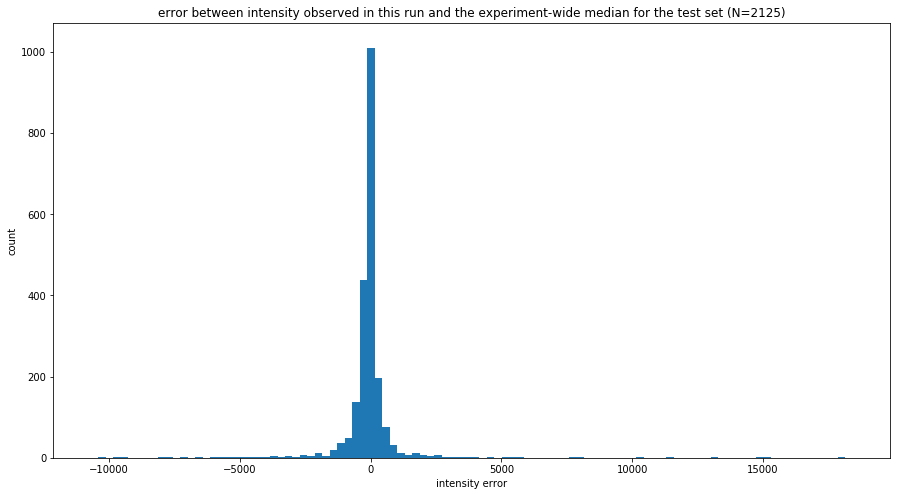

In [334]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('error between intensity observed in this run and the experiment-wide median for the test set (N={})'.format(len(y_test_predicted)))

bins = 100
hist, bins, _ = plt.hist(intensity_df.pre_adjustment_intensity_error, bins=bins, label='intensity error')
plt.xlabel('intensity error')
plt.ylabel('count')

plt.show()

plot intensity error after adjustment

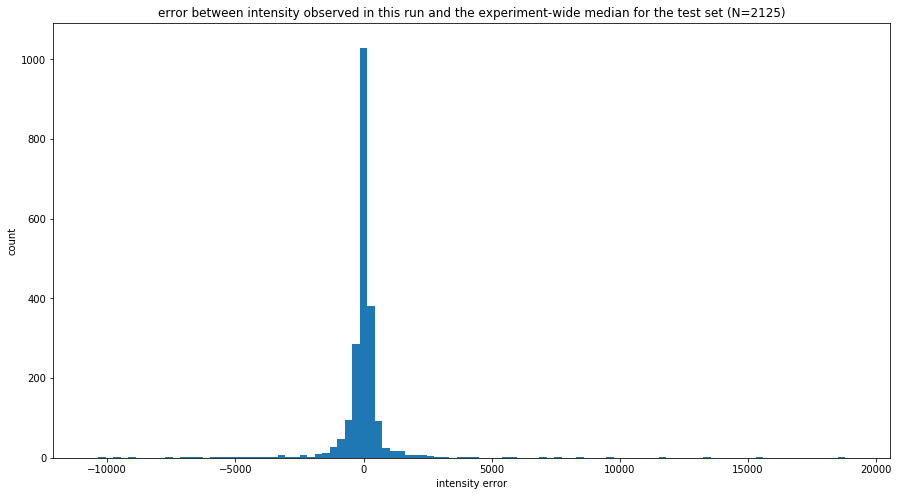

In [335]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('error between intensity observed in this run and the experiment-wide median for the test set (N={})'.format(len(y_test_predicted)))

bins = 100
hist, bins, _ = plt.hist(intensity_df.post_adjustment_intensity_error, bins=bins, label='intensity error')
plt.xlabel('intensity error')
plt.ylabel('count')

plt.show()

In [303]:
# save the trained model
with open('/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/intensity-models/file-{}-intensity-model.pkl'.format(file_idx_for_this_model), 'wb') as file:
    pickle.dump(best_estimator, file)